In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda")

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST("data", transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

In [52]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = torch.nn.Linear(28*28, 500)
        self.fc2 = torch.nn.Linear(500, 200)
        self.fc3 = torch.nn.Linear(200, 1)
        
        self.activation = torch.nn.LeakyReLU(0.2)
        self.sigmoid = torch.nn.functional.sigmoid
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Linear(80, 300)
        self.fc2 = torch.nn.Linear(300, 500)
        #self.fc2 = torch.nn.Linear(300, 400)
        self.fc3 = torch.nn.Linear(500, 28*28)
        
        self.activation = torch.nn.LeakyReLU(0.2)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x

In [53]:
discriminator= Discriminator().to(device)
generator = Generator().to(device)

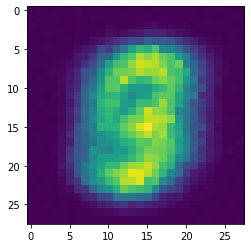

In [63]:
test_noise = torch.tensor(np.random.normal(0, 1, size=(1, 80)), dtype=torch.float).to(device)
test_img = generator(test_noise).view(28, 28).detach().cpu().numpy()
plt.imshow(test_img)

In [64]:
# standard Adam learning rate
disc_lr = 3e-5
gen_lr = 3e-5

epochs = 2
batch_size=32

In [59]:
criterion = torch.nn.BCELoss()
#mse_loss = torch.nn.MSELoss()

disc_optim = torch.optim.Adam(discriminator.parameters(), lr=disc_lr)
gen_optim = torch.optim.Adam(generator.parameters(), lr=gen_lr)

In [60]:
real_output = torch.ones(32, dtype=torch.float).to(device)
#prob_output = torch.tensor([0.9] * 32).to(device)
fake_output = torch.zeros(32, dtype=torch.float).to(device)

In [65]:
discriminator_loss = []
generator_loss = []

for e in tqdm(range(epochs)):
    for i, b in enumerate(trainloader):
        mnist_img = b[0].view(-1, 28*28).to(device)
        #print(b[1])
        noise = torch.tensor(np.random.normal(0, 1, size=(32, 80)), dtype=torch.float).to(device)
        
        gen_img = generator(noise)
        
        gen_disc_loss = criterion(discriminator(gen_img).view(32), real_output)
        gen_img_loss = mse_loss(gen_img, mnist_img)
        
        gen_loss = (gen_disc_loss + gen_img_loss)/2
        
        gen_optim.zero_grad()
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
        
        disc_loss_real = criterion(discriminator(mnist_img).view(32), real_output)
        disc_loss_fake = criterion(discriminator(gen_img).view(32).detach(), fake_output)
        disc_loss = (disc_loss_real + disc_loss_fake)/2
        
        disc_optim.zero_grad()
        disc_loss.backward()
        disc_optim.step()
        
    discriminator_loss.append(disc_loss.item())
    generator_loss.append(gen_loss.item())
        #plt.clf()
        #img = gen_img.detach().numpy()
        #plt.imshow(img)
        #plt.draw()

100%|████████████████████████████████████████████| 2/2 [00:40<00:00, 20.34s/it]


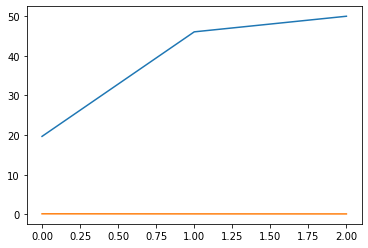

In [51]:
plt.plot(discriminator_loss)
plt.plot(generator_loss)